<a href="https://colab.research.google.com/github/fdelattre/BibleReco/blob/main/Bible_NLP_SpaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application de quelques techniques NLP sur les textes bibliques

Le corpus biblique en français est disponible intégralement en ligne sur le site de l'[Association Épiscopale Liturgique pour les pays Francophones](https://www.aelf.org/bible).

Le texte a été scrappé depuis le site internet et formatté comme ceci :

| Champ | Description |
|---|---|
| TESTAMENT | Ancien 'AT', Nouveau 'NT' ou Psaumes 'PS' |
| LIVRE | Titre du livre (ex : "Lettre de Saint Paul Apôtre aux Romains") |
| CODE_LIVRE | Code du livre (ex : Rm) |
| CHAPITRE | Numéro du chapitre dans le livre |
| URL | Url sur le site de l'AELF |
| VERSET | numéro du verset |
| TEXTE | Texte du verset |

Dans ce notebook, nous appliquerons quelques techniques de nettoyage de texte. Nous tenterons ensuite de visualiser les proximités qui existent entre les textes. Enfin, nous proposerons une sorte de moteur de recommandation biblique.

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [79]:
import pandas as pd
filepath = '/gdrive/MyDrive/Colab Notebooks/bible_aelf.parquet.gzip'
data = pd.read_parquet(filepath)
data.sample(5)

,TESTAMENT,LIVRE,CODE_LIVRE,CHAPITRE,URL,VERSET,TEXTE
7508,NT,Deuxième lettre de saint Paul Apôtre aux Thess...,2Th,3,https://www.aelf.org/bible/2Th/3,14,Si quelqu’un n’obéit pas à ce que nous disons ...
13490,AT,Livre d'Ezekiel,Ez,22,https://www.aelf.org/bible/Ez/22,06,Les princes d’Israël répandent chez toi le san...
9778,AT,Livre de Daniel,Dn,4,https://www.aelf.org/bible/Dn/4,26,"Douze mois après, comme il se promenait sur la..."
14833,AT,Livre de la Genèse,Gn,18,https://www.aelf.org/bible/Gn/18,17,Le Seigneur s’était dit : « Est-ce que je vais...
3033,AT,Premier livre des Rois,1R,14,https://www.aelf.org/bible/1R/14,19,"Le reste des actions de Jéroboam,\nses combats..."


# Transformations de texte

## Nettoyage du texte
* Passage en minuscules
* retrait des signes de ponctuation et des chiffres
* retrait des stopwords en se basant sur la liste [Stopwords ISO](https://github.com/stopwords-iso)

In [80]:
! pip install stopwordsiso

In [81]:
import stopwordsiso as stopwords
import re

def clean_text(txt, remove_stop_words = False):
  
  txt_clean         =  ''.join([re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', r.lower()) for r in txt])
  
  if remove_stop_words:
    stopWords         = set(stopwords.stopwords("fr"))  # French stopwords
    txt_clean = ' '.join([item for item in txt_clean.split() if item not in stopWords])
  
  return str.rstrip(txt_clean)

In [83]:
data['TEXTE_CLEAN'] = data['TEXTE'].apply(clean_text, remove_stop_words = True)

data.sample(5)

,TESTAMENT,LIVRE,CODE_LIVRE,CHAPITRE,URL,VERSET,TEXTE,TEXTE_CLEAN
18955,AT,Livre de Judith,Jdt,10,https://www.aelf.org/bible/Jdt/10,07,"Quand ils virent Judith le visage transformé, ...",virent judith visage transformé portant vêteme...
2474,NT,Première lettre de saint Pierre Apôtre,1P,3,https://www.aelf.org/bible/1P/3,16,mais faites-le avec douceur et respect. Ayez u...,douceur respect conscience adversaires pris ho...
8838,NT,Livre de l'Apocalypse,Ap,1,https://www.aelf.org/bible/Ap/1,20,Quant au mystère des sept étoiles que tu as vu...,mystère étoiles vues main chandeliers or étoil...
10482,AT,Livre du Deutéronome,Dt,12,https://www.aelf.org/bible/Dt/12,21,Si tu es trop loin du lieu que le Seigneur ton...,loin lieu seigneur dieu choisi mettre nom pour...
31330,PS,Livre des Psaumes,Ps,98,https://www.aelf.org/bible/Ps/98,09,"Exaltez le Seigneur notre Dieu, + prosternez-v...",exaltez seigneur dieu prosternez sainte montag...


## Etude de fréquences de mots

Les données étant à la granularité du verset, on procède au regroupement des textes par Livre

In [84]:
df_livres = data.groupby(['TESTAMENT', 'LIVRE', 'CODE_LIVRE'], as_index=False)['TEXTE_CLEAN'].apply(' '.join)
df_livres.sample(5)

,TESTAMENT,LIVRE,CODE_LIVRE,TEXTE_CLEAN
61,NT,Lettre de saint Paul Apôtre aux Philippiens,Ph,paul timothee serviteurs christ jésus sanctifi...
67,NT,Première lettre de saint Jean,1Jn,etait commencement entendu yeux contemplé main...
8,AT,Livre d'Aggée,Ag,deuxieme annee règne darius jour mois seigneur...
24,AT,Livre de Jérémie,Jr,paroles jeremie fils helkias prêtres anatoth p...
69,NT,Première lettre de saint Paul Apôtre aux Thess...,1Th,paul silvain timothee église thessalonique die...


In [85]:
def return_most_frequent(txt, n_most_frequent=5):
  most_frequent= pd.Series(txt.split()).value_counts()[:n_most_frequent].to_dict()
  return dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))


df_livres['MOST_FREQUENT_TERMS'] = df_livres['TEXTE_CLEAN'].apply(return_most_frequent, n_most_frequent=10)

df_livres[['LIVRE', 'CODE_LIVRE', 'MOST_FREQUENT_TERMS']]

,LIVRE,CODE_LIVRE,MOST_FREQUENT_TERMS
0,Cantique des cantiques,Ct,"{'aimé': 33, 'ur': 23, 'belle': 14, 'filles': ..."
1,Deuxième Livre des Martyrs d'Israël,2M,"{'roi': 80, 'judas': 72, 'juifs': 63, 'dieu': ..."
2,Deuxième livre de Samuel,2S,"{'roi': 269, 'david': 263, 'seigneur': 191, 'f..."
3,Deuxième livre des Chroniques,2Ch,"{'seigneur': 401, 'roi': 275, 'maison': 200, '..."
4,Deuxième livre des Rois,2R,"{'roi': 371, 'seigneur': 293, 'fils': 187, 'is..."
...,...,...,...
69,Première lettre de saint Paul Apôtre aux Thess...,1Th,"{'dieu': 37, 'seigneur': 25, 'frères': 17, 'jé..."
70,Première lettre de saint Paul Apôtre à Timothée,1Tm,"{'foi': 25, 'dieu': 25, 'christ': 16, 'jésus':..."
71,Première lettre de saint Pierre Apôtre,1P,"{'dieu': 45, 'christ': 22, 'gloire': 13, 'grâc..."
72,Troisième lettre de saint Jean,3Jn,"{'vérité': 6, 'témoignage': 5, 'aimé': 4, 'égl..."


L'analyse des occurences de mots nous donne quelques éclairages intéressants.
Par exemple, dans le [Cantique des cantiques](https://fr.wikipedia.org/wiki/Cantique_des_Cantiques), les mots 'amour' et 'aimé' sont les plus présents !
Jésus est bien le protagoniste principal des évangiles avec des associations intéressantes comme Jésus/Dieu chez Jean et Jésus/Dieu chez Luc. Alors que chez Marc et Mathieu, c'est Jésus/Homme qui est en tête.

# Visualisation

## Vectorisation

La vectorisation consiste à transformer un texte en une représentation matricielle ayant pour colonnes les mots de vocabulaire présents dans le texte.
Ex :

| Texte                         | aime | les | pommes | poires | deteste | et |
|-------------------------------|:----:|:---:|:------:|--------|---------|----|
| aime les pommes               | 1    | 1   | 1      | 0      | 0       | 0  |
| aime les poires et les poires | 1    | 2   | 0      | 2      | 0       | 1  |
| déteste les pommes            | 0    | 1   | 1      | 0      | 1       | 0  |

On obtient ainsi une matrice contenant autant de lignes que de texte et autant de colonnes que de mots présents dans les textes.

Nous utiliserons la fonction [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) de la librairie sklearn.
Cette transformation va plus [loin](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) qu'un simple comptage d'occurence en donnant plus ou moins d'importance aux mots selon leur fréquence d'apparition

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tf_idf_mod = TfidfVectorizer(ngram_range=(1,2))
vec_res = tf_idf_mod.fit_transform(df_livres['TEXTE_CLEAN']).toarray()

In [87]:
vec_res.shape

(74, 255733)

La matrice obtenue est donc de dimension  `vec_res.shape = (74, 252512)`

L'étape suivante consistera à réduire cette dimension afin de pouvoir visualiser notre corpus



## Réduction de dimension et visualisation

In [88]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

Une des méthodes les plus courantes de réduction de dimension est l'[analyse en composantes principales](https://)

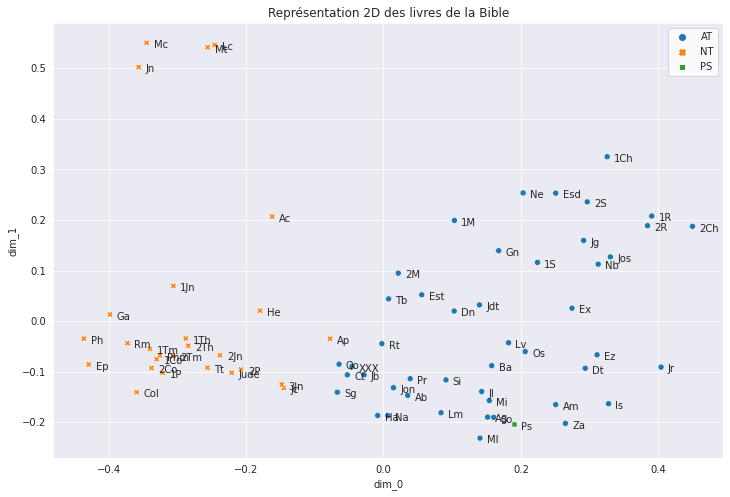

In [89]:
pca_mod = PCA(n_components=2)
X = pca_mod.fit_transform(vec_res)

df_livres_vectorized = pd.DataFrame({
    'testament' : df_livres['TESTAMENT'],
    'code_livre': df_livres['CODE_LIVRE'],
    'dim_0' : X[:,0],
    'dim_1' : X[:,1]})

plt.figure(figsize=(12,8))#, dpi=300)
sns.set_style("darkgrid")

g = sns.scatterplot(data=df_livres_vectorized, x='dim_0', y='dim_1', hue = 'testament', style="testament")
g.legend(facecolor = 'white')
g.set_title("Représentation 2D des livres de la Bible")

for i, txt in enumerate(df_livres_vectorized['code_livre']):
  g.annotate(s=txt, 
             xy=(df_livres_vectorized.loc[i, 'dim_0']+0.01, df_livres_vectorized.loc[i, 'dim_1']-0.01))

La visualisation graphique basée uniquement sur le contenu des texte est riche d'enseignements.
* La distinction Ancient Testament / Nouveau testament est très marquée.
* Au sein du groupe du Nouveau Testament, 2 groupes principaux
 * les 4 évangiles
 * Les lettres
* Le livre de l'Apocalypse est le livre du NT qui se rapproche le plus du groupe de l'AT.
* Les Actes des Apôtres, qui n'est ni un récit de la vie du Christ comme les Evangiles, ni un ensemble d'exhortations comme les Lettres, se retrouve isolé.


# Moteur de recommandation biblique

## Vectorisation par vecteurs Spacy

Nous avons vu plus haut qu'il est indispensable de transformer les textes en vecteurs numériques pour pouvoir les utiliser dans les algorithmes de traitement de données. Alors que nous avions utilisé la méthode Td-Idf, nous allons maintenant associer à chaque texte un vecteur calculé au préalable sur un [corpus](https://spacy.io/models/fr#fr_core_news_lg) d'articles de journaux.
Dans le model fr_core_news_lg proposé par la library spaCy, 500k vecteurs de dimension 300 sont mis à disposition, correspondant à 500k mots.

Chaque verset sera donc associé à un vecteur de dimension 300. Le vecteur d'un verset étant la moyenne des vecteurs des mots qui le composent.

Le principe du moteur de recommandation sera le suivant ↙
- Entrée d'un texte par l'utilisateur (quelques mots suffisent)
- Attribution d'un vecteur à ce texte
- Identification et présentation des versets les plus proches

Tout d'abord, une fonction permettant de trouver le vecteur spaCy d'un texte

In [90]:
def return_sentence_vector(sentence):
  doc = nlp(sentence)
  return doc.vector

Le corpus biblique est enrichi des vecteurs pour chacun des versets (temps de calcul environ 5 minutes).

Le corpus enrichi est sauvegardé pour pouvoir être réutilisé.

In [91]:
# dure 5 minutes
vectors = data['TEXTE_CLEAN'].apply(return_sentence_vector)
df_vectors = pd.DataFrame(data = [vec for vec in vectors], columns = ['v'+str(i) for i in range(0, len(vectors[0]))])

df = pd.concat([data, df_vectors], axis=1)
df.to_parquet('/gdrive/MyDrive/Colab Notebooks/bible_aelf_vectors.parquet.gzip',compression='gzip')

## Moteur de recommandation



In [93]:
data = pd.read_parquet('/gdrive/MyDrive/Colab Notebooks/bible_aelf_vectors.parquet.gzip')

In [ ]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import numpy as np

def propose_passage(txt, nb_proposions = 10, filter=None):

  better_phrase = clean_text(txt, remove_stop_words=True)
  vector = return_sentence_vector(better_phrase)
  
  if filter is not None:
    filtered_data = data.loc[data['TESTAMENT']==filter, :].reset_index()
    vector_subset = filtered_data.loc[:,filtered_data.columns.str.startswith('v')]
    distances = cosine_distances(vector.reshape((1, -1)), vector_subset).reshape(-1)
    result = filtered_data.loc[np.argsort(distances, )[:nb_proposions], ['URL', 'TEXTE']]
  else:
    vector_subset = data.loc[:, data.columns.str.startswith('v')]
    distances = cosine_distances(vector.reshape((1, -1)), vector_subset).reshape(-1)
    result = data.loc[np.argsort(distances, )[:nb_proposions], ['URL', 'TEXTE']]
  
  return result

In [165]:
propose_passage('marie comblée de grâce', nb_proposions = 10, filter=None)

,URL,TEXTE
11078,https://www.aelf.org/bible/Ep/1,"à la louange de gloire de sa grâce,\nla grâce ..."
34142,https://www.aelf.org/bible/Si/26,"La grâce de la femme enchante son mari,\net se..."
16283,https://www.aelf.org/bible/He/13,La grâce soit avec vous tous.
15225,https://www.aelf.org/bible/Gn/30,"Rachel reprit : « Voici ma servante Bilha, uni..."
32770,https://www.aelf.org/bible/Rm/11,"Et si c’est par grâce, ce n’est pas par les œu..."
35316,https://www.aelf.org/bible/Za/4,"Qui es-tu, grande montagne ?\nDevant Zorobabel..."
22786,https://www.aelf.org/bible/Lc/1,"L’ange lui dit alors : « Sois sans crainte, Ma..."
22784,https://www.aelf.org/bible/Lc/1,"L’ange entra chez elle et dit : « Je te salue,..."
19799,https://www.aelf.org/bible/Jn/1,"Tous nous avons eu part à sa plénitude,\nnous ..."
31165,https://www.aelf.org/bible/Ps/88,Tu es sa force éclatante ; ta grâce accroît no...
